In [2]:
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

%load_ext autoreload
%autoreload 2

In [3]:
import growth_model as gm
import tox_model as tm
import scheduler as sch
import file_manipulation as fm

In [52]:
# read json file patient_config.json
with open('patient_config.json') as f:
    patient_config = json.load(f)
print("patient config:", patient_config)
doses = [1, 0.5, 0.1]

patient config: {'toxicity': 1.6433127155860012, 'burden': 0.8708684897640193, 'r': 0.7319939418114051, 'a': 0.5986584841970366, 's1': 0.15601864044243652, 's2': 0.15599452033620265, 's3': 0.05808361216819946, 's4': 0.8661761457749352, 'tx1': 0.6011150117432088, 'tx2': 0.7080725777960455, 'tx3': 0.020584494295802447, 'tx4': 0.9699098521619943, 'clear': 0.8324426408004217, 'start_strike': 1, 'start_cycle': 1}


In [57]:
def eval(config, plan):
    schedule = sch.plan_to_schedule(
        *plan, patient_config["start_strike"], patient_config["start_cycle"]
    )
    duration = int(sch.duration(schedule))
    toxicities = fm.get_toxicities(config)
    tox, breaks = tm.RunToxDifferenceEquation(
        config["toxicity"], 0, duration, schedule, toxicities, config["r"], 10.0
    )
    new_schedule = tm.GenNewSched(schedule, breaks)
    growth_solution = gm.tumour_growth(
        config["burden"], duration, new_schedule, config["a"], plan
    )
    return {
        "plan": plan,
        "schedule": new_schedule,
        "toxicity_sol": tox,
        "burden_sol": growth_solution,
    }


def score_burden(burden_sol):
    return gm.final_tumour_volume(burden_sol)


def score_toxicity(toxicity_sol):
    return np.mean(toxicity_sol)


def score_total(toxicity, burden):
    return burden - toxicity

In [53]:
start_time = time.time()
plans = [(t1, t2, t3, t4) for t1 in doses for t2 in doses for t3 in doses for t4 in doses]
sols = [eval(patient_config, plan) for plan in plans]

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tested {len(plans)} treatment schedules.")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

Tested 81 treatment schedules.
Elapsed Time: 37.8285 seconds


In [58]:
scored_plans = [[*sol["plan"], score_burden(sol["burden_sol"]), score_toxicity(sol["toxicity_sol"])] for sol in sols]
df_sp = pd.DataFrame(scored_plans, columns = ["S1", "S2", "S3", "S4", "burden", "toxicity"])
df_sp["total_score"] = score_total(df_sp["toxicity"], df_sp["burden"])
df_sp.head()

,S1,S2,S3,S4,burden,toxicity,total_score
0,1.0,1.0,1.0,1.0,4.402197e-172,2.035365,-2.035365
1,1.0,1.0,1.0,0.5,3.779722e-129,1.866169,-1.866169
2,1.0,1.0,1.0,0.1,9.581679e-115,1.730813,-1.730813
3,1.0,1.0,0.5,1.0,6.954132e-140,1.905943,-1.905943
4,1.0,1.0,0.5,0.5,6.018958e-97,1.736748,-1.736748


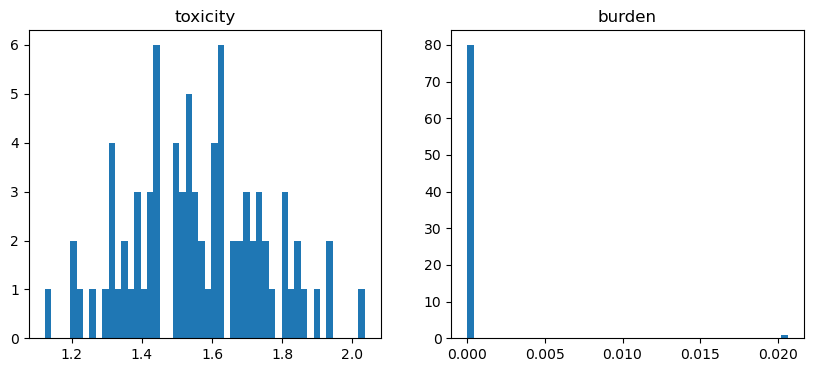

In [59]:
# plot two histograms for cost and benefit
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(df_sp["toxicity"], bins=50)
ax[0].set_title("toxicity");
ax[1].hist(df_sp["burden"], bins=50)
ax[1].set_title("burden");

Text(0.5, 1.0, 'Cost vs Benefit for All Treatment Schedules')

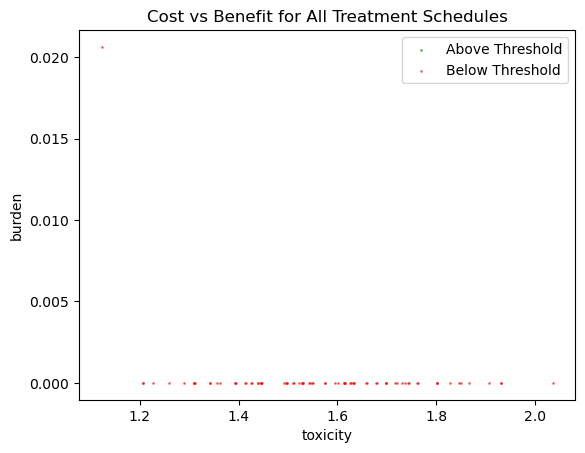

In [62]:
threshold = 0.1 # arbitrary threshold

above_threshold = df_sp.loc[df_sp["total_score"] > threshold]
below_threshold = df_sp.loc[df_sp["total_score"] <= threshold]
plt.scatter(above_threshold["toxicity"], above_threshold["burden"], s=1, alpha=0.5, c="green", label="Above Threshold")
plt.scatter(below_threshold["toxicity"], below_threshold["burden"], s=1, alpha=0.5, c="red", label="Below Threshold")

# add a line at y = x - 1.5
# x = np.linspace(0, 1, 100)
# y = x * 0.01 + threshold
# plt.plot(x, y, c="black")

plt.xlabel("toxicity")
plt.ylabel("burden")
plt.legend()
plt.title("Cost vs Benefit for All Treatment Schedules")